**Install dependencies**

In [ ]:
from IPython.display import clear_output

clear_output(wait=True)

!pip install tensorflow
!pip install spectral
!pip install matplotlib
!pip install scikit-learn
!pip install -q git+https://github.com/tensorflow/docs
!pip install ipympl



**Check if tensorflow is running on GPU and use seeds for reproducible results**

In [1]:
import tensorflow as tf
print(f"Available GPUS: {tf.config.list_physical_devices('GPU')}")
tf.random.set_seed(42)
import numpy as np
np.random.seed(42)

Available GPUS: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Define some useful constants**

In [2]:
BATCH_SIZE=32
BANDS = 64
PATCH_SIZE = 64

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import glob
import shutil
import os
import cv2

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks
class LRFinder(callbacks.Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-8, end_lr: float = 10., max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

**Normalizing the data**

Let's define a method that can normalize a tensor to range 0-1, according to the formula:
<br/>
<img src="https://www.oreilly.com/library/view/regression-analysis-with/9781788627306/assets/ffb3ac78-fd6f-4340-aa92-cde8ae0322d6.png" alt="drawing" width="300"/>
<br/>
This method will be used later.

In [4]:
import tensorflow as tf

def normalize_tensor(nd_array : np.ndarray) -> np.ndarray:
    return (tf.divide(
       tf.subtract(
          nd_array, 
          tf.reduce_min(nd_array)
       ), 
       tf.subtract(
          tf.reduce_max(nd_array), 
          tf.reduce_min(nd_array)
       )
    )).numpy()

**Define some useful methods**

In [5]:
import spectral
import numpy as np

# Calculate indexes of equally spaced K bands to keep
bands = np.round(np.linspace(0, 272 - 1, BANDS)).astype(int)

def find_label(folder_name:str)->int:
    if "NORMAL" in folder_name:
        return 0
    if "INFECTED" in folder_name:
        return 1
def label_int2str(label:int):
    if label ==0:
        return "NORMAL"
    if label ==1:
        return "INFECTED"

def get_input(path, resize: int = None ):
    """ Reads HSI from disk """
    folder_contents = sorted(glob.glob(path+"/**"))
    #print(path)
    hdr_file = list(filter(lambda file: ".hdr" in file, folder_contents))[0]
    #print(hdr_file)
    # .hdr image is at index 0. Resize image to common size. Keep only K Bands
    image = spectral.open_image(hdr_file).load()[:702, :640,bands].astype(np.float32)
    if resize is None:
        return normalize_tensor(image)
    else:
        return normalize_tensor(cv2.resize(image, (0,0), fx=resize, fy=resize))
    

def get_label(folder_name:str)->int:
    """ Finds the label for a image"""
    if "NORMAL" in folder_name:
        return 0
    if "INFECTED" in folder_name:
        return 1

def load_features(x_files, resize:int = None):
    """ Loads the features X"""
    return np.array([get_input(img, resize) for img in x_files])

def load_labels(x_files):
    """ Loads the labels"""
    return np.fromiter((get_label(img) for img in x_files), int)

def crop_black_borders(img,tol=0):
    # Get number of bands
    n_bands = img.shape[2]
    # Get a image with 3 random bands
    new_img = img[:,:, np.random.choice(n_bands, 3)]
    # Convert to grayscale
    gray = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
    # Apply tresholding
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    # Make treshold uint8
    thresh = thresh.astype(np.uint8)
    # Find contours
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # Get biggest contour
    contour = max(contours, key=cv2.contourArea)
    # Get bounding box of this contour
    x,y,w,h = cv2.boundingRect(contour)
    # Crop to bouding box
    crop = img[y:y+h,x:x+w, :]
    return crop


# 1. Clean the dataset

In [10]:
# Grab the image folders dirs
image_folders = sorted(glob.glob(
    "../input/grapesoriginal/dataset_original/*",
))


# Grab the mask dirs
mask_dirs = glob.glob(
    "../input/grapesmasks/masks/**/mask.*",
    recursive=True,
)

# Mask dirs contains .psd files. Use list comprehension to remove them. Sort them by number (ascending).
# This is important so mask order matches image folder order
mask_dirs = list(filter(lambda path: ".psd" not in path, mask_dirs))
mask_dirs = sorted(mask_dirs, key = lambda file : int(file.split('/')[-2].split('_')[1]))

base_dir = "cleaned_dataset/"
# Ensure that new directory is created
if os.path.exists(base_dir):
    shutil.rmtree(base_dir, ignore_errors=True)

# Lambda function to process mask (Make it binary)
process_mask = lambda mask: np.where(mask > 0, 255, 0) / 255


for i, folder in enumerate(image_folders):
    # Get the folder name
    current_folder_name = folder.split("/")[-1]
    # Extract the label. 1 is 'pos' in folder name, 0 otherwise
    label = "INFECTED" if "pos" in current_folder_name else "NORMAL"
    # Build new folder name
    new_folder_name = f"{current_folder_name.split('_')[0]}_{label}"
    
    # If folder does not exist, create it
    os.makedirs(base_dir + new_folder_name)
    # Find the contents of the folder
    folder_files = glob.glob(folder + "/**")
    # Filter for the .hdr file
    image_file = list(filter(lambda file: ".hdr" in file, folder_files))[0]
    # Load the .hdr file
    image = spectral.open_image(image_file).load()
    # Load the mask and process it
    mask = process_mask(cv2.imread(mask_dirs[i], 0)).astype(np.int8)   
    # Apply mask to image
    print(f"Image {current_folder_name}:")
    print(f"\tApplying binary mask ({mask_dirs[i]})")
    image = cv2.bitwise_and(image,image,mask = mask)
    # Get final path
    path = base_dir + new_folder_name + "/" + new_folder_name
    # Save .hdr image in final path
    print(f"\tSaving raw version ({path})")
    spectral.envi.save_image(path + ".hdr", image, dtype=np.float32)
    # Save .jpg version with 3 random bands
    print(f"\tSaving jpg version ({path})")
    spectral.save_rgb(path + ".jpg", image, [29, 19, 9])
    print("**"*50)


Image A01V04_2018_10_11_14_04_21:
	Applying binary mask (../input/grapesmasks/masks/mask_1/mask.png)
	Saving raw version (cleaned_dataset/A01V04_NORMAL/A01V04_NORMAL)
	Saving jpg version (cleaned_dataset/A01V04_NORMAL/A01V04_NORMAL)
****************************************************************************************************
Image A01V07_2018_10_11_14_05_28:
	Applying binary mask (../input/grapesmasks/masks/mask_2/mask.png)
	Saving raw version (cleaned_dataset/A01V07_NORMAL/A01V07_NORMAL)
	Saving jpg version (cleaned_dataset/A01V07_NORMAL/A01V07_NORMAL)
****************************************************************************************************
Image A01V10_(A03V30)a_EXTRA_2018_10_11_11_40_11_pos:
	Applying binary mask (../input/grapesmasks/masks/mask_3/mask.png)
	Saving raw version (cleaned_dataset/A01V10_INFECTED/A01V10_INFECTED)
	Saving jpg version (cleaned_dataset/A01V10_INFECTED/A01V10_INFECTED)
***********************************************************************

# 2. Non-Patched Aproach

## 2.1 Load Images and labels

In [11]:
import glob
import numpy as np
import random
# Get dataset folders
dataset_folders =  np.array(glob.glob("./cleaned_dataset/**"))
# Shuffle folders
random.shuffle(dataset_folders)
# Load features (reducing size, keeping n %)
X = load_features(dataset_folders, 0.20)
y = load_labels(dataset_folders)

In [12]:
# Display the features and labels shape
print(f"Features shape: {X.shape}. Target shape: {y.shape}")

Features shape: (35, 140, 128, 64). Target shape: (35,)


## 2.2 Baseline model

First let's define a method that can create a baseline model (CNN)

In [6]:
from tensorflow.keras import layers, metrics, Model, optimizers, losses
# Method for creating a baseline model
def build_baseline(input_shape, add_dropout_layers=False, fully_connected_size = 512):
    input_img = layers.Input(shape=input_shape)
    
    # Conv 1
    x = layers.Conv2D(32, 3)(input_img)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Conv 2
    x = layers.Conv2D(64, 3)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Conv 3
    x = layers.Conv2D(64, 3)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Flatten()(x)
    
    # Fully-connected 1
    x = layers.Dense(fully_connected_size, activation= 'relu')(x)
    
    if add_dropout_layers:
        x = layers.Dropout(0.5)(x)
    
    # Fully-connected 2
    x = layers.Dense(fully_connected_size, activation= 'relu')(x)
    
    if add_dropout_layers:
        x = layers.Dropout(0.5)(x)
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(x)
    
    # Build model
    model = Model(input_img, output)
    
    # Compile the model
    model.compile(optimizer = optimizers.Adam(), loss=losses.BinaryCrossentropy())
    
    return model


Now let's define a method that can implement the LeaveOneOut Cross-validation

In [14]:
from sklearn.model_selection import LeaveOneOut
from sklearn.utils.class_weight import compute_class_weight
# Garbage Collector
import gc

# Define method for performing Leave-One-Out Cross-validation
def perform_loocv(build_fn, X, y, epochs):
    """
    Method for performing Leave-One-Out Cross-validation
    
    Parameters
    ----------
    build_fn: function
        A function that returns a compiled tf.keras.Model
    X: np.ndarray
        A numpy array with the features of shape (n_images, width, height, n_channels)
    y: np.ndarray
        A numpy array with the labels (n_images,)
    epochs: int
        How many epochs should each model be trained on
    
    Returns
    -------
    y_true : list
        A list containing the true labels for each of the test instance
    y_pred_proba: list
        A list containing the predicted probability for each of the test instance
    fold_train_loss: list
        A list containing the history training loss
    fold_test_loss: list
        A list containing the history test loss
    """
    
    # Create 2 empty lists for holding the true labels and the probabilities
    y_true, y_pred_proba = list(), list()
    
    # Create 2 empty lists for holding the training history losses and test history losses
    fold_train_loss, fold_test_loss = list(), list()
    
    # Perform CV
    for k, (train_idx, test_idx) in enumerate(LeaveOneOut().split(X)):

        # Train data
        x_train, x_test = X[train_idx], X[test_idx]
        # Test data
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Compute class weights for balanced learning. Returns a list
        weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
        
        # Convert the list do dict.
        weights_dict = {idx: value for idx, value in enumerate(weights)}
        
        # Call the function to build the model
        model = build_fn()
        
        # Train the model with the training indices
        history = model.fit(x_train, y_train, batch_size = 1, validation_data = (x_test, y_test),
                           epochs=epochs, 
                           verbose=0,
                           class_weight = weights_dict)
        fold_train_loss.append(history.history["loss"])
        fold_test_loss.append(history.history["val_loss"])


        # Delete train from memory
        del x_train
        del y_train
        gc.collect()

        # Evaluate the model with the testing indices,
        # `predict_step` because `predict` is causing retracing
        # See: https://github.com/tensorflow/tensorflow/issues/42441
        # `predict_step` returns a tensor
        y_predicted_proba = model.predict_step(x_test).numpy()[0][0]
        print(f"Fold {k+1} - Target: {y_test[0]} | Predicted proba: {y_predicted_proba:.2f}")
        # Save predictions and real label
        y_true.append(y_test[0])
        y_pred_proba.append(y_predicted_proba)

        del x_test
        del y_test
        gc.collect()
    
    return (y_true, y_pred_proba, fold_train_loss, fold_test_loss)



In [7]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y, y_prob, title):
    """Plots ROC Curve"""
    # Calculate Roc Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=title)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()

Let's define one more method that can plot the learning curves from our cross-validation, so we can visually inspect on how our model is performing.

In [8]:
def plot_loocv_loss(fold_train_loss, fold_test_loss, title):
    train_loss_mean = np.mean(fold_train_loss, axis=0)
    train_loss_std = np.std(fold_train_loss, axis=0)

    test_loss_mean = np.mean(fold_test_loss, axis=0)
    test_loss_std = np.std(fold_test_loss, axis=0)

    epochs = list(range(1,len(train_loss_mean) + 1))

    plt.fill_between(epochs, train_loss_mean - train_loss_std,
                             train_loss_mean + train_loss_std, alpha=0.1,
                             color="r")
    plt.fill_between(epochs, test_loss_mean - test_loss_std,
                             test_loss_mean + test_loss_std, alpha=0.1,
                             color="g")

    plt.plot(epochs, train_loss_mean, 'o-', color="r",
                     label="Training loss")
    plt.plot(epochs, test_loss_mean, 'o-', color="g",
                     label="Test loss")
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Binary Crossentropy Loss')
    plt.title(title)
    plt.gca().set_ylim(bottom=0)
    plt.show()

**Let's train a baseline model with no regularization**

Fold 1 - Target: 0 | Predicted proba: 0.00
Fold 2 - Target: 0 | Predicted proba: 0.00
Fold 3 - Target: 0 | Predicted proba: 1.00
Fold 4 - Target: 0 | Predicted proba: 0.00
Fold 5 - Target: 1 | Predicted proba: 0.80
Fold 6 - Target: 0 | Predicted proba: 0.00
Fold 7 - Target: 1 | Predicted proba: 0.01
Fold 8 - Target: 0 | Predicted proba: 0.00
Fold 9 - Target: 0 | Predicted proba: 0.01
Fold 10 - Target: 0 | Predicted proba: 0.18
Fold 11 - Target: 0 | Predicted proba: 0.00
Fold 12 - Target: 0 | Predicted proba: 0.00
Fold 13 - Target: 1 | Predicted proba: 0.02
Fold 14 - Target: 0 | Predicted proba: 0.00
Fold 15 - Target: 1 | Predicted proba: 0.99
Fold 16 - Target: 1 | Predicted proba: 1.00
Fold 17 - Target: 0 | Predicted proba: 0.00
Fold 18 - Target: 0 | Predicted proba: 0.00
Fold 19 - Target: 0 | Predicted proba: 1.00
Fold 20 - Target: 1 | Predicted proba: 0.26
Fold 21 - Target: 0 | Predicted proba: 0.00
Fold 22 - Target: 0 | Predicted proba: 0.00
Fold 23 - Target: 1 | Predicted proba: 0.

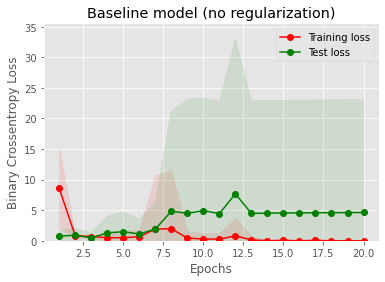

In [14]:
%matplotlib inline

from tensorflow.keras import optimizers, losses
from sklearn.metrics import confusion_matrix, classification_report

# Perform cv
y_true, y_pred_proba, \
fold_train_loss, fold_test_loss = perform_loocv(lambda: build_baseline(X.shape[1:]) , X, y, epochs=20)

# Plot the loss curve
plot_loocv_loss(fold_train_loss, fold_test_loss, "Baseline model (no regularization)")

              precision    recall  f1-score   support

      Normal       0.81      0.88      0.85        25
    Infected       0.62      0.50      0.56        10

    accuracy                           0.77        35
   macro avg       0.72      0.69      0.70        35
weighted avg       0.76      0.77      0.76        35

AUC: 0.74


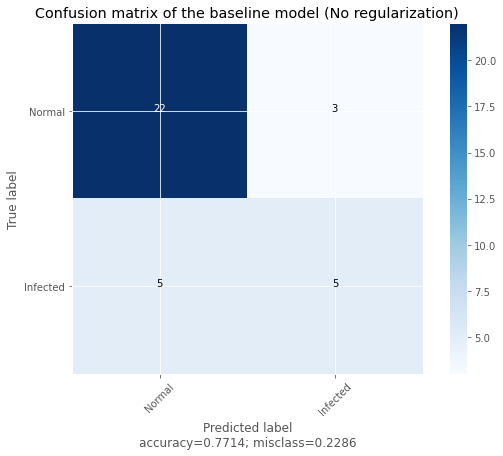

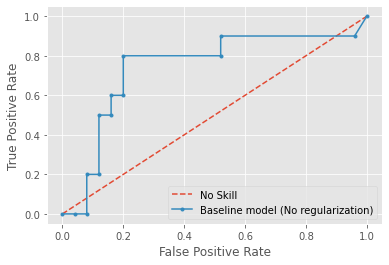

In [15]:
from sklearn.metrics import roc_auc_score

# Treshold probabilities for 0.5
y_pred = (np.array(y_pred_proba) > 0.5).astype(np.int32)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Infected"]))
print(f"AUC: {roc_auc_score(y_true, y_pred_proba):.2f}")
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

%matplotlib inline
# Plot the confusion matrix
plot_confusion_matrix(cm, target_names = ["Normal", "Infected"], title='Confusion matrix of the baseline model (No regularization)', normalize=False)

plot_roc_curve(y_true, y_pred_proba, "Baseline model (No regularization)")

As we can see the baseline model is suffering from overfit. The `recall` for the positive class is 0.5, indicating that the model is not very good at predicting infected samples.

**Let's now train the same model. But let's add dropout layers as a regularization mechanism, and reduce the number of neurons in the fully-connected layers**

Fold 1 - Target: 0 | Predicted proba: 0.00
Fold 2 - Target: 0 | Predicted proba: 0.17
Fold 3 - Target: 0 | Predicted proba: 1.00
Fold 4 - Target: 0 | Predicted proba: 0.00
Fold 5 - Target: 1 | Predicted proba: 0.57
Fold 6 - Target: 0 | Predicted proba: 0.01
Fold 7 - Target: 1 | Predicted proba: 0.47
Fold 8 - Target: 0 | Predicted proba: 0.00
Fold 9 - Target: 0 | Predicted proba: 0.15
Fold 10 - Target: 0 | Predicted proba: 0.00
Fold 11 - Target: 0 | Predicted proba: 0.03
Fold 12 - Target: 0 | Predicted proba: 0.11
Fold 13 - Target: 1 | Predicted proba: 0.00
Fold 14 - Target: 0 | Predicted proba: 0.00
Fold 15 - Target: 1 | Predicted proba: 0.86
Fold 16 - Target: 1 | Predicted proba: 1.00
Fold 17 - Target: 0 | Predicted proba: 0.00
Fold 18 - Target: 0 | Predicted proba: 0.00
Fold 19 - Target: 0 | Predicted proba: 0.80
Fold 20 - Target: 1 | Predicted proba: 0.54
Fold 21 - Target: 0 | Predicted proba: 0.00
Fold 22 - Target: 0 | Predicted proba: 0.00
Fold 23 - Target: 1 | Predicted proba: 0.

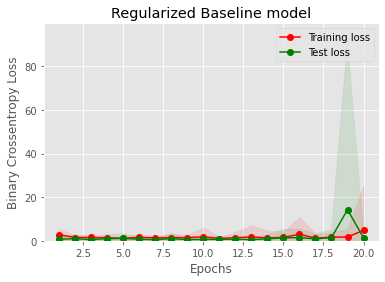

In [16]:
f = lambda: build_baseline(X.shape[1:], add_dropout_layers=True , fully_connected_size=64) 
# Perform cv
y_true, y_pred_proba, \
fold_train_loss, fold_test_loss = perform_loocv(f, X, y, epochs=20)

# Plot the loss curve
plot_loocv_loss(fold_train_loss, fold_test_loss, "Regularized Baseline model")

Now we can that the model is not suffering from overfitting

              precision    recall  f1-score   support

      Normal       0.83      0.80      0.82        25
    Infected       0.55      0.60      0.57        10

    accuracy                           0.74        35
   macro avg       0.69      0.70      0.69        35
weighted avg       0.75      0.74      0.75        35

AUC: 0.75


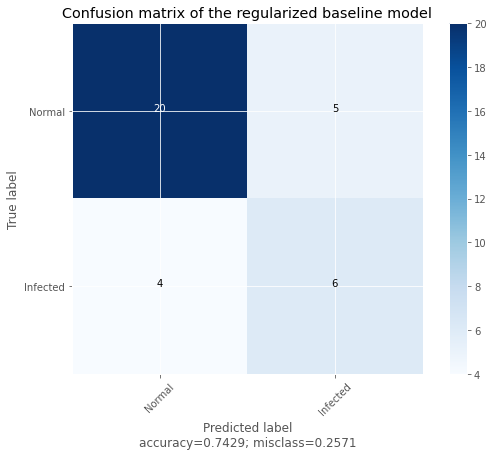

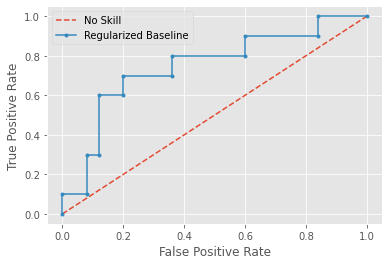

In [17]:
# Treshold probabilities for the best treshold found
y_pred = (np.array(y_pred_proba) > 0.5).astype(np.int32)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Infected"]))
print(f"AUC: {roc_auc_score(y_true, y_pred_proba):.2f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

%matplotlib inline
# Plot the confusion matrix
plot_confusion_matrix(cm, target_names = ["Normal", "Infected"], title='Confusion matrix of the regularized baseline model', normalize=False)

plot_roc_curve(y_true, y_pred_proba, 'Regularized Baseline')

We have a recall increase of 10 % but all the other metrics have decreased.

## 2.3 Using an AutoEncoder
Let's try to build an autoencoder that can encode and decode the images, when we can use autoencoder to perform feature extracting on the original images.

### 2.3.1 Training the AutoEncoder

In [19]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [20]:
from tensorflow.keras import Model, layers, regularizers

class Autoencoder(Model):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        
        # Define encoder
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=input_shape),
          layers.Conv2D(32, (3,3), padding='same'), 
          layers.LeakyReLU(0.2),
          layers.Conv2D(16, (3,3),  padding='same'),
          layers.LeakyReLU(0.2)
        ])
        
        # Define decoder (Provide input_shape for automatic model build)
        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(16, kernel_size=3, padding='same', input_shape = self.encoder.layers[-1].output_shape[1:] ),
          layers.LeakyReLU(0.2),
          layers.Conv2DTranspose(32, kernel_size=3, padding='same'),
          layers.LeakyReLU(0.2),
          layers.Conv2D(BANDS, kernel_size=(3,3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Let's split our `X` into `train (80%)` and `test (20%)` portions

In [21]:
from sklearn.model_selection import train_test_split
# Split X
x_train, x_test = train_test_split(X, test_size=0.2, random_state=42, stratify=y)
# Build a model
autoencoder = Autoencoder(x_train.shape[1:])

In [22]:
print(f"x_train shape: {x_train.shape} | x_test shape: {x_test.shape}")

x_train shape: (28, 140, 128, 64) | x_test shape: (7, 140, 128, 64)


**Finding an optimal learning rate for the autoencoder**

Epoch 1/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1956
Epoch 2/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1956
Epoch 3/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1950
Epoch 4/10
28/28 [==============================] - 0s 8ms/step - loss: 0.1567
Epoch 5/10
28/28 [==============================] - 0s 7ms/step - loss: 0.0711
Epoch 6/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0598
Epoch 7/10
28/28 [==============================] - 0s 7ms/step - loss: 0.0598
Epoch 8/10
28/28 [==============================] - 0s 7ms/step - loss: 0.0598


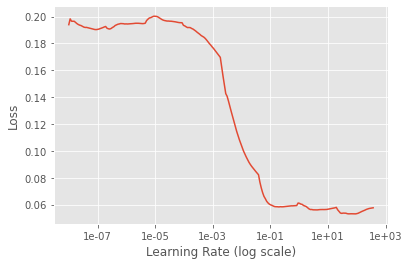

In [23]:
from tensorflow.keras import optimizers

# Define the callback
learning_rate_finder = LRFinder(end_lr=30, max_steps=200)

autoencoder = Autoencoder(x_train.shape[1:])

# Compile the model
autoencoder.compile(optimizer=optimizers.Adam(), loss = 'mse')

# Train the model for 5 epochs
_ = autoencoder.fit(x_train,
                    x_train, 
                    epochs=10,
                    batch_size = 1,
                    verbose=1, 
                    callbacks = [learning_rate_finder])
%matplotlib inline 
# Plot the loss with Learning rate evolution
learning_rate_finder.plot()
plt.show()

From inspecting the graph above, we can see that using a learning rate in range `[1e-3 , 1e-2]`, we obtained the sharpest decrease in loss. This suggests that we can start with `1e-2` and reduce the learning rate when hitting a plateau until the minimum of `1e-3`. 


Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0009.


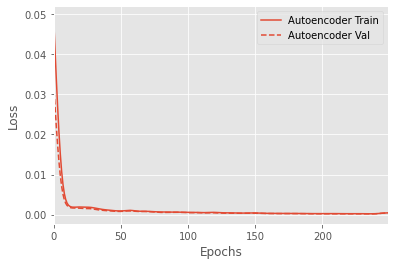

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

# Build autoencoder
autoencoder = Autoencoder(X.shape[1:])

# Prepare callbacks
# 1. Reduce learning rate when loss is on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=15, min_lr=9e-4, verbose=1)
# 2. Early stopping
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=20, mode="auto", verbose=0, restore_best_weights=True)

# Compile the model
autoencoder.compile(optimizer=optimizers.Adam(lr=1e-3), loss = 'mse')
# Train the model
history = {}
history["autoencoder"] = autoencoder.fit(x_train, x_train, 
                                        validation_split=0.2,
                                        batch_size = 1,
                                        epochs = 250,
                                        verbose = 0,
                                        callbacks=[reduce_lr,early_stop])

# Plot the loss history
%matplotlib inline 
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(history)


### 2.3.2 Inspecting the reconstructions on test data

1/1 [==============================] - 0s 2ms/step - loss: 2.2981e-04


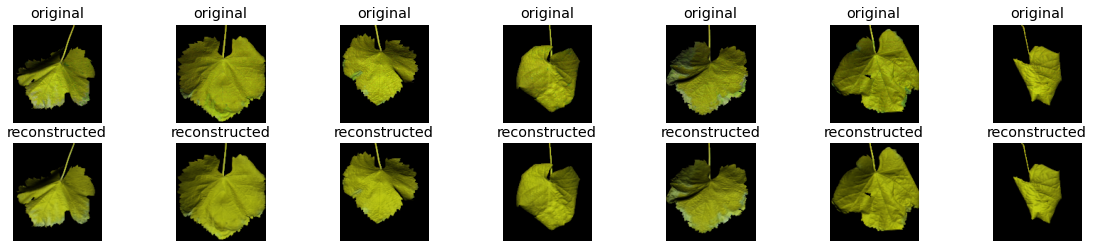

In [26]:
# `predict_step` to avoid retracing
autoencoder.evaluate(x_test, x_test)
decoded_imgs = autoencoder.predict_step(x_test).numpy()
# Plot n decoded images, maximum 10
n = min(decoded_imgs.shape[0], 10)
plt.figure(figsize=(20, 4))

# Select 3 random bands to display
display_bands = np.random.choice(BANDS,3)

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i][:,:,display_bands])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i][:,:,display_bands])
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### 2.3.3 Transfer-learning the Encoder

In [27]:
del x_train
del x_test
gc.collect()

20

In [38]:

from tensorflow.keras import layers, losses, optimizers, metrics

class FullyConnectedEncoder(tf.keras.Model):
    def __init__(self, autoencoder):
        super(FullyConnectedEncoder, self).__init__()
        self.encoder = autoencoder.encoder
        # Freeze the encoder
        self.encoder.trainable = False
        # Pooling
        self.make_1d = layers.GlobalAveragePooling2D()
        
        self.fc_1 = layers.Dense(128)
        self.activation_1 = layers.LeakyReLU(0.3)
        self.dropout1 = layers.Dropout(0.5)
        
        self.fc_2 = layers.Dense(128)
        self.activation_2 = layers.LeakyReLU(0.3)
        self.dropout2 = layers.Dropout(0.5)
        
        self.classifier = layers.Dense(1, 'sigmoid')
        
    def call(self, x):
        encoded = self.encoder(x)
        x = self.make_1d(x)
        
        x = self.fc_1(x)
        x = self.activation_1(x)
        x = self.dropout1(x)
        
        x = self.fc_2(x)
        x = self.activation_2(x)
        x = self.dropout2(x)

        return self.classifier(x)


Fold 1 - Target: 0 | Predicted proba: 0.29
Fold 2 - Target: 1 | Predicted proba: 0.53
Fold 3 - Target: 1 | Predicted proba: 0.56
Fold 4 - Target: 1 | Predicted proba: 0.13
Fold 5 - Target: 0 | Predicted proba: 0.37
Fold 6 - Target: 0 | Predicted proba: 0.29
Fold 7 - Target: 1 | Predicted proba: 0.64
Fold 8 - Target: 0 | Predicted proba: 0.50
Fold 9 - Target: 0 | Predicted proba: 0.50
Fold 10 - Target: 0 | Predicted proba: 0.66
Fold 11 - Target: 0 | Predicted proba: 0.46
Fold 12 - Target: 0 | Predicted proba: 0.20
Fold 13 - Target: 0 | Predicted proba: 0.19
Fold 14 - Target: 1 | Predicted proba: 0.65
Fold 15 - Target: 0 | Predicted proba: 0.27
Fold 16 - Target: 1 | Predicted proba: 0.53
Fold 17 - Target: 0 | Predicted proba: 0.50
Fold 18 - Target: 0 | Predicted proba: 0.45
Fold 19 - Target: 1 | Predicted proba: 0.51
Fold 20 - Target: 0 | Predicted proba: 0.35
Fold 21 - Target: 0 | Predicted proba: 0.31
Fold 22 - Target: 0 | Predicted proba: 0.50
Fold 23 - Target: 0 | Predicted proba: 0.

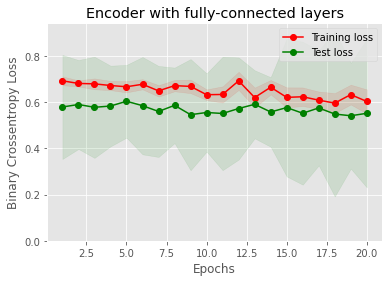

In [40]:
def fc_encoder_fn():
    model = FullyConnectedEncoder(autoencoder)
    model.compile(optimizer = optimizers.Adam(lr=1e-3), loss=losses.BinaryCrossentropy())
    return model

# Perform cv
y_true, y_pred_proba, \
fold_train_loss, fold_test_loss = perform_loocv(fc_encoder_fn , X, y, epochs=20)

# Plot the loss curve
plot_loocv_loss(fold_train_loss, fold_test_loss, "Encoder with fully-connected layers")

              precision    recall  f1-score   support

      Normal       0.91      0.84      0.87        25
    Infected       0.67      0.80      0.73        10

    accuracy                           0.83        35
   macro avg       0.79      0.82      0.80        35
weighted avg       0.84      0.83      0.83        35

AUC: 0.83


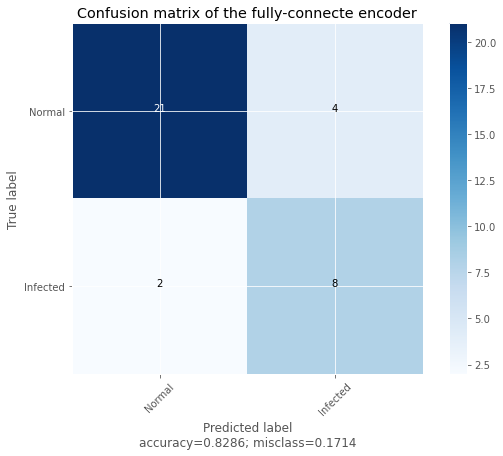

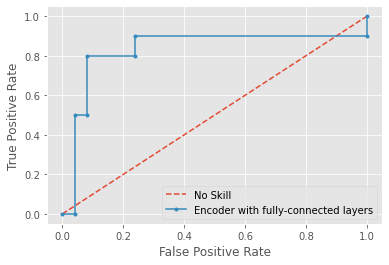

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Treshold probabilities
y_pred = (np.array(y_pred_proba) > 0.5).astype(np.int32)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Infected"]))
print(f"AUC: {roc_auc_score(y_true, y_pred_proba):.2f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

%matplotlib inline
# Plot the confusion matrix
plot_confusion_matrix(cm, target_names = ["Normal", "Infected"], title='Confusion matrix of the fully-connecte encoder', normalize=False)

plot_roc_curve(y_true, y_pred_proba, "Encoder with fully-connected layers")

In [ ]:
model = fc_encoder_fn()
model.summary()

As we can observe our model is much better at predicting the infected samples, without a huge sacrifice in normal samples recall

# 3. Patched Approach
With this approach we generate a bigger dataset by extracting patches of each image.
Then we use Holdout Cross-validation to evaluate the models. For this we first divide the dataset into folds prior to patching.

## 3.1. Splitting the dataset into 6 stratified folds (1 holdout)

In [11]:
import glob
from sklearn.model_selection import StratifiedKFold
from distutils.dir_util import copy_tree
import shutil

# Find cleaned dataset folders
dataset_folders = glob.glob(
    "cleaned_dataset/**"
)
# Find labels for the folders
labels = load_labels(dataset_folders)

folds=[]
for _, test_folder_idx in StratifiedKFold(n_splits=6, shuffle=True).split(dataset_folders, labels):
    folds.append(np.array(dataset_folders)[test_folder_idx]) 


base_dir = "splitted_dataset"
# Ensure that new directory is created
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)
    
# Save the folds
for k, fold in enumerate(folds):
    print(f"Saving fold {k+1}")
    dest_dir = base_dir+ f"/fold_{k+1}/"
    os.mkdir(dest_dir)
    for file in fold:
        final_dest = dest_dir + file.split("\\")[1]
        os.mkdir(final_dest)
        copy_tree(file, final_dest)

Saving fold 1
Saving fold 2
Saving fold 3
Saving fold 4
Saving fold 5
Saving fold 6


## 3.2. Patching the Folds
Here we extract patches of size `(n,n)` for each image in the dataset. The patches are overlaped, sharing 20% of the previous image.

In [ ]:
import numpy as np
# For getting file locations
import glob
import spectral
import os
import shutil

def patchify(image:np.ndarray)->np.ndarray:
    # Save number of channels
    n_channels = image.shape[2]
    
    # Make image a batch
    image = tf.expand_dims(image, 0)
    
    patches = tf.image.extract_patches(
        images=image,
        sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
        strides=[1, PATCH_SIZE * 0.80, PATCH_SIZE * 0.80, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    # Perform reshape
    patches = tf.reshape(patches, (-1, PATCH_SIZE, PATCH_SIZE, n_channels))
    
    # Delete patches than are >=40 % black
    final_patches= []
    for patch in patches:
        # Calculate total number of pixels
        number_total_pixels = np.prod(patch.shape)
        # Calculate total number of black pixels (0)
        number_black_pixels = np.count_nonzero(patch==0)
        # Calculate black pixels ration
        black_pixels_ratio = number_black_pixels / number_total_pixels
        # If patch is less than 40% black, keep it
        if black_pixels_ratio < 0.4:
            final_patches.append(patch)   
    # Return patches as np array
    return np.array(final_patches)

def patchify_folds(folds_folders:list, destination:str):
    
    # If already exists, delete entire tree
    if os.path.exists(destination):
        # Force delete
        shutil.rmtree(destination, ignore_errors=True)
    
    for fold_folder in folds_folders:
        # Grab name of current fold
        current_fold = fold_folder.split('\\')[1]
        # Search for folder contents
        fold_images = glob.glob(fold_folder + "/*")

        # Iterate over each image folder present in the current fold
        for image_folder in fold_images:
            # Get file name
            file_name = image_folder.split('\\')[-1].split('.hdr')[0]
            print(f"File {file_name}:")
            # Search folder contents
            image_folder_contents = sorted(glob.glob(image_folder + "/*"))
            # Get the .hdr file
            image_file = list(filter(lambda file: ".hdr" in file, image_folder_contents))[0]
            # Load the .hdr file
            image = spectral.open_image(image_file).load()
            # Generate patches
            image_patches = patchify(image)
            print(f"\tGenerated {len(image_patches)} patches of size ({PATCH_SIZE}, {PATCH_SIZE})")
            for i, patch in enumerate(image_patches):
                # Generate new format name, ie: "IMAGE_1_PATCH_2_NORMAL"
                new_image_name = f"{file_name}_PATCH_{i+1}"
                # Generate path
                path = f"{destination}/{current_fold}/{new_image_name}/"
                # Create folders
                os.makedirs(path)
                # Create final path
                final_path = f"{path}{new_image_name}"
                # Save the patch
                spectral.envi.save_image(final_path + ".hdr", patch, dtype=np.float32)
                # Save rgb version
                spectral.save_rgb(final_path + ".jpg", patch, [29, 19, 9])
            print("**"*30)

In [ ]:
import glob
# Search for the folds
folds_folders = glob.glob("splitted_dataset/*")

# Patchify the folds, using the last one for the holdout
patchify_folds(folds_folders, destination = "patched_dataset")


## 3.3. Selecting the train folds and the holdout fold

In [9]:
import glob
import numpy as np

# Grab folds folders (fold_1, ..., fold_k)
folds_folders = glob.glob("patched_dataset/**")

# Randomly select 1 fold for being the holdout final test
holdout_fold = np.random.choice(folds_folders, 1)[0]

# Keep the rest for training and performing k-fold
# Search for elements of `folds_folders` that are not in `holdout_fold`
train_folds = np.setdiff1d(folds_folders,holdout_fold)

print(f"Train folds: {train_folds}")
print(f"Holdout fold: {holdout_fold}")

Train folds: ['patched_dataset\\fold_1' 'patched_dataset\\fold_2'
 'patched_dataset\\fold_3' 'patched_dataset\\fold_5'
 'patched_dataset\\fold_6']
Holdout fold: patched_dataset\fold_4


**Let's inspect how many samples we have in our data**

In [10]:
def print_fold_stats(fold_folder=None, fold_labels=None):
    """ Display fold stats by receiving the folder or the labels"""
    if fold_labels is None:
        # Get the folder images of this fold
        fold_images = sorted(glob.glob(fold_folder + "/*"))
        # load the labels for this images
        fold_labels = load_labels(fold_images)
    
    # Calculate number of positive labels
    positive_labels = np.sum(np.array(fold_labels) == 1)
    # Calculate number of negative labels
    negative_labels = np.sum(np.array(fold_labels) == 0) 
    # Calculate total number of labels
    total_labels = len(fold_labels)
    
    print(f"\tNumber of images: {len(fold_labels)}")
    print(f"\tNumber of positive samples: {positive_labels} ({(positive_labels/(total_labels))*100:.2f} %)")
    print(f"\tNumber of negative samples: {negative_labels} ({(negative_labels/(total_labels))*100:.2f} %)")
    print("**"*30)

for k, fold in enumerate(train_folds):
    # Print current fold
    print(f"Train Fold {k+1}:")
    print_fold_stats(fold)

# Now for the holdout fold
print("Holdout Fold:")
print_fold_stats(holdout_fold)


Train Fold 1:
	Number of images: 383
	Number of positive samples: 52 (13.58 %)
	Number of negative samples: 331 (86.42 %)
************************************************************
Train Fold 2:
	Number of images: 326
	Number of positive samples: 70 (21.47 %)
	Number of negative samples: 256 (78.53 %)
************************************************************
Train Fold 3:
	Number of images: 441
	Number of positive samples: 99 (22.45 %)
	Number of negative samples: 342 (77.55 %)
************************************************************
Train Fold 4:
	Number of images: 414
	Number of positive samples: 131 (31.64 %)
	Number of negative samples: 283 (68.36 %)
************************************************************
Train Fold 5:
	Number of images: 352
	Number of positive samples: 19 (5.40 %)
	Number of negative samples: 333 (94.60 %)
************************************************************
Holdout Fold:
	Number of images: 325
	Number of positive samples: 55 (16.92 %)
	Numbe

As we have a lot of samples, requiring huge memory allocation, let's load 100% of positive samples of each fold, and `k` random negative samples to match the positive ones.

In [11]:
import random

def load_fold(fold):
    """Balances, shuffles, loads and normalizes a fold"""
    # Search all image folders of this fold
    image_folders = glob.glob(fold + "/*")    
    # Load labels for the images of this fold
    image_labels = load_labels(image_folders)
   
    # Grab indexs of positive labels
    positive_labels_indexs = np.argwhere(image_labels == 1)[:,0]
   
    # Grab indexs of negative labels and select 'k' to match size of positive labels
    negative_labels_indexs = np.random.choice(np.argwhere(image_labels == 0)[:,0], len(positive_labels_indexs))
       
    # Concat the indexes
    total_indexs = np.concatenate((positive_labels_indexs, negative_labels_indexs), axis=None)
   
    # Use the indexes to filter the image_folders
    selected_images = np.array(image_folders)[total_indexs]
    random.shuffle(selected_images)
    # Use the indexes to filter the image labels
    selected_images_labels = load_labels(selected_images)

    # Return a tupple of the normalized images and the respective labels
    return load_features(selected_images), selected_images_labels


# Load test images and labels
print("Loading holdout fold images")
images, labels = load_fold(holdout_fold)
test_data = (images, labels)
# Creat list for holding the training datasets folds
train_data_list = []
for k, fold in enumerate(train_folds):
    print(f"Loading images of training fold {k+1}")
    # Load the normalized images to list
    images, labels = load_fold(fold)
    # Save images in dict with labels as value
    train_data_list.append([images, labels]) 


Loading holdout fold images
Loading images of training fold 1
Loading images of training fold 2
Loading images of training fold 3
Loading images of training fold 4
Loading images of training fold 5


**Confirm that every fold is normalized**

In [12]:
def print_pixel_range(name:str, data)->None:
    print(f"{name} pixel range: {np.min(data)}--{np.max(data)}")

print_pixel_range("Holdout fold", test_data[0]) 

for k, (images, _) in enumerate(train_data_list):
    print_pixel_range(f"Train fold {k+1}", images) 

Holdout fold pixel range: 0.0--1.0
Train fold 1 pixel range: 0.0--1.0
Train fold 2 pixel range: 0.0--1.0
Train fold 3 pixel range: 0.0--1.0
Train fold 4 pixel range: 0.0--1.0
Train fold 5 pixel range: 0.0--1.0


**Display the new fold stats**

In [13]:
for k, (_, labels) in enumerate(train_data_list):
    # Print current fold
    print(f"Train Fold {k+1}:")
    print_fold_stats(fold_labels = labels )

# Now for the holdout fold
print("Holdout Fold:")
print_fold_stats(fold_labels = test_data[1])

Train Fold 1:
	Number of images: 104
	Number of positive samples: 52 (50.00 %)
	Number of negative samples: 52 (50.00 %)
************************************************************
Train Fold 2:
	Number of images: 140
	Number of positive samples: 70 (50.00 %)
	Number of negative samples: 70 (50.00 %)
************************************************************
Train Fold 3:
	Number of images: 198
	Number of positive samples: 99 (50.00 %)
	Number of negative samples: 99 (50.00 %)
************************************************************
Train Fold 4:
	Number of images: 262
	Number of positive samples: 131 (50.00 %)
	Number of negative samples: 131 (50.00 %)
************************************************************
Train Fold 5:
	Number of images: 38
	Number of positive samples: 19 (50.00 %)
	Number of negative samples: 19 (50.00 %)
************************************************************
Holdout Fold:
	Number of images: 110
	Number of positive samples: 55 (50.00 %)
	Number of

## 3.4 Establishing a baseline

**Method for building the baseline model**

In [17]:
def build_train_data(train_list, indices_to_keep, batch=True):
    train = np.array(train_list, dtype=object)[indices_to_keep]
    x = []
    y = []
    for item in train:
        x.append(item[0])
        y.append(item[1])
        
    return np.concatenate(x, axis=0), np.concatenate(y, axis=0)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Create lists for holding the metric values
acc_per_fold=[] # accuracy
auc_per_fold=[] # AUC
loss_per_fold=[] # loss


# Create 2 empty lists for holding the training history losses and test history losses
fold_train_loss, fold_test_loss = list(), list()

# Iterate an index to size of folds
for i in range(len(train_data_list)):
    print(f"Split {i+1}/{len(train_folds)}")

    # Extract validation data
    x_val, y_val = train_data_list[i]
    
    # Indices for train
    indices_to_keep = np.delete(range(len(train_data_list)), i)
    
    # Get train data
    x_train, y_train = build_train_data(train_data_list, indices_to_keep)
    
    # Compute class weights for balanced learning. Returns a list
    weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)

    # Convert the list do dict.
    weights_dict = {idx: value for idx, value in enumerate(weights)}
        
    # Build the model
    baseline_model = build_baseline((PATCH_SIZE,PATCH_SIZE,BANDS), add_dropout_layers=True, fully_connected_size = 128)
    # Compile the model
    baseline_model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
            metrics=[metrics.BinaryAccuracy(), metrics.AUC(name='auc')]
              )
    
    # Train the model with the training indices
    history = baseline_model.fit(x_train,y_train,
                       validation_data=(x_val, y_val),
                       batch_size=64,
                       epochs=40,
                       class_weight= weights_dict,
                       verbose=0)
    
    fold_train_loss.append(history.history["loss"])
    fold_test_loss.append(history.history["val_loss"])
    # Evaluate the model with the testing indices
    scores = baseline_model.evaluate(x_val, y_val, verbose=0) 

    # Scores has format : ['loss', 'binary_accuracy', 'auc']
    # Save the loss value on the val data
    loss_per_fold.append(scores[0])
    # Save the Accuracy value on the val data
    acc_per_fold.append(scores[1])
    # Save the Accuracy value on the val data
    auc_per_fold.append(scores[2])


Split 1/5
Split 2/5
Split 3/5
Split 4/5
Split 5/5


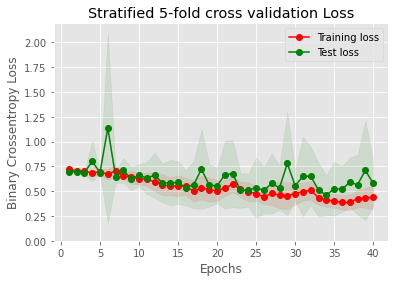

Accuracy: 0.70 (+/- 0.16)
AUC: 0.66 (+/- 0.24)


In [14]:
plot_loocv_loss(fold_train_loss, fold_test_loss, "Stratified 5-fold cross validation Loss")
# Transform the lists into numpy arrays for calculations
acc_per_fold=np.array(acc_per_fold)
auc_per_fold=np.array(auc_per_fold)

# Display the results
print(f"Accuracy: {acc_per_fold.mean():.2f} (+/- {acc_per_fold.std():.2f})")
print(f"AUC: {auc_per_fold.mean():.2f} (+/- {auc_per_fold.std():.2f})")

**How does the model perfom on unseen data?**

In [16]:
result = baseline_model.evaluate(test_data[0], test_data[1], batch_size=64)
result = dict(zip(baseline_model.metrics_names, result))
print(result)


2/2 [==============================] - 0s 247ms/step - loss: 2.7299 - binary_accuracy: 0.6364 - auc: 0.5843
{'loss': 2.729891777038574, 'binary_accuracy': 0.6363636255264282, 'auc': 0.5842975974082947}


## 3.2 Autoencoder

**Defining the AutoEncoder architecture**

In [37]:
from tensorflow.keras import Model

class Autoencoder(Model):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        
        # Define encoder
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=input_shape),
          layers.Conv2D(32, (3,3), padding='same', ),
          layers.LeakyReLU(0.2),
          layers.Conv2D(24, (3,3),  padding='same'),
          layers.LeakyReLU(0.2),
        ])
        
        # Define decoder (Provide input_shape for automatic model build)
        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(24, kernel_size=3, padding='same', input_shape = self.encoder.layers[-1].output_shape[1:]),
          layers.LeakyReLU(0.2),
          layers.Conv2DTranspose(32, kernel_size=3, padding='same',),
          layers.LeakyReLU(0.2),
          layers.Conv2D(BANDS, kernel_size=(3,3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

**Finding an optimal learning rate**

In [38]:
# Get train data
x_train, _ = build_train_data(train_data_list, range(len(train_data_list)))
x_test = test_data[0]

In [39]:
print(f"Train shape: {x_train.shape} | Test shape: {x_test.shape}")

Train shape: (742, 64, 64, 64) | Test shape: (110, 64, 64, 64)


Epoch 1/5
47/47 [==============================] - 3s 50ms/step - loss: 0.1217
Epoch 2/5
47/47 [==============================] - 3s 57ms/step - loss: 0.0851
Epoch 3/5
47/47 [==============================] - 0s 9ms/step - loss: 0.1493


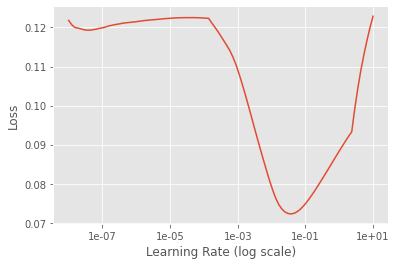

In [40]:
# Define the callback
learning_rate_finder = LRFinder()

autoencoder=Autoencoder(x_train.shape[1:])

# Compile the model
autoencoder.compile(optimizer=optimizers.Adam(), loss = 'mse')

# Train the model for 5 epochs
_ = autoencoder.fit(x_train,
                    x_train, 
                    batch_size = 16,
                    epochs=5, 
                    verbose=1, 
                    callbacks = [learning_rate_finder])

# Plot the loss with Learning rate evolution
learning_rate_finder.plot()


From inspecting the graph above, we can see that using a learning rate of `[1e-3,1e-2]`, we obtained the sharpest decrease in loss. This suggests that this value is the optimal learning rate for our model.

**Training the Autoencoder with the optimal learning rate**

Epoch 1/250
38/38 [==============================] - 5s 94ms/step - loss: 0.0548 - val_loss: 0.0192
Epoch 2/250
38/38 [==============================] - 3s 67ms/step - loss: 0.0170 - val_loss: 0.0087
Epoch 3/250
38/38 [==============================] - 2s 65ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 4/250
38/38 [==============================] - 2s 59ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 5/250
38/38 [==============================] - 3s 71ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 6/250
38/38 [==============================] - 3s 72ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/250
38/38 [==============================] - 2s 62ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/250
38/38 [==============================] - 2s 62ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 9/250
38/38 [==============================] - 3s 74ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 10/250
38/38 [==============================] - 3s 75ms/step - loss: 0.0018 - val_loss: 0.0014

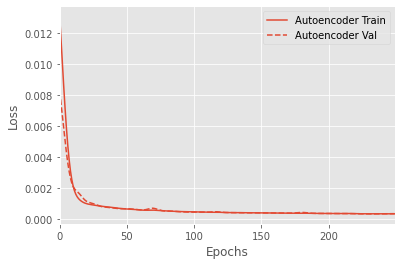

In [42]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

autoencoder=Autoencoder(x_train.shape[1:])

# Prepare callbacks
# 1. Reduce learning rate when loss is on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=15, min_lr=9e-4, verbose=1)
# 2. Early stopping
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=20, mode="auto", verbose=0, restore_best_weights=True)

# Compile the model
autoencoder.compile(optimizer=optimizers.Adam(lr=1e-3), loss = 'mse')
# Train the model
history = {}
history["autoencoder"] = autoencoder.fit(x_train, x_train, 
                                        validation_split=0.2,
                                        batch_size = 16,
                                        epochs = 250,
                                        verbose = 1,
                                        callbacks=[reduce_lr,early_stop])

# Plot the loss history
%matplotlib inline 
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(history)


7/7 [==============================] - 0s 26ms/step - loss: 4.7081e-04


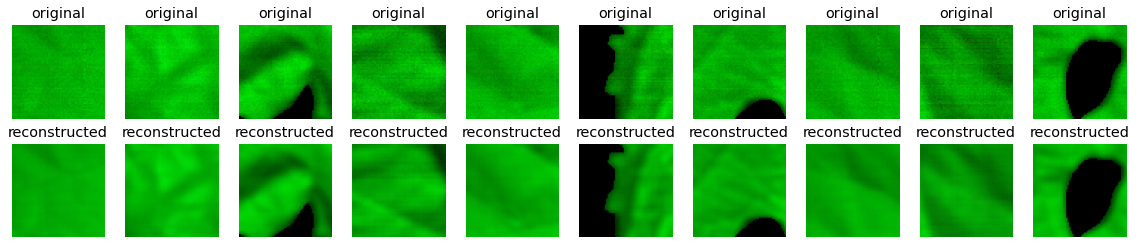

In [44]:
# `predict_step` to avoid retracing
autoencoder.evaluate(x_test, x_test, batch_size=16)
decoded_imgs = autoencoder.predict_step(x_test).numpy()
# Plot n decoded images, maximum 10
n = min(decoded_imgs.shape[0], 10)
plt.figure(figsize=(20, 4))

# Select 3 random bands to display
display_bands = np.random.choice(BANDS,3)

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i][:,:,display_bands])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i][:,:,display_bands])
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## 3.3 Transfer-learning the Encoder

In [47]:
from tensorflow.keras import layers, losses, optimizers

def fully_connected_enc():
    
    encoder = autoencoder.encoder
    # Freeze the encoder
    encoder.trainable=False


    inputs = layers.Input(shape=x_train.shape[1:])

    x = encoder(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model  = tf.keras.Model(inputs,outputs)
    return model

In [48]:
from sklearn.utils.class_weight import compute_class_weight
# Create lists for holding the metric values
acc_per_fold=[] # accuracy
auc_per_fold=[] # AUC
loss_per_fold=[] # loss


# Create 2 empty lists for holding the training history losses and test history losses
fold_train_loss, fold_test_loss = list(), list()

# Iterate an index to size of folds
for i in range(len(train_data_list)):
    print(f"Split {i+1}/{len(train_folds)}")

    # Extract validation data
    x_val, y_val = train_data_list[i]
    
    # Indices for train
    indices_to_keep = np.delete(range(len(train_data_list)), i)
    
    # Get train data
    x_train, y_train = build_train_data(train_data_list, indices_to_keep)
    
    # Compute class weights for balanced learning. Returns a list
    weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)

    # Convert the list do dict.
    weights_dict = {idx: value for idx, value in enumerate(weights)}
        
    # Build the model
    model = fully_connected_enc()
    # Compile the model
    model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
            metrics=[metrics.BinaryAccuracy(), metrics.AUC(name='auc')]
              )
    
    # Train the model with the training indices
    history = model.fit(x_train,y_train,
                       validation_data=(x_val, y_val),
                       batch_size=64,
                       epochs=40,
                       class_weight= weights_dict,
                       verbose=0)
    
    fold_train_loss.append(history.history["loss"])
    fold_test_loss.append(history.history["val_loss"])
    # Evaluate the model with the testing indices
    scores = model.evaluate(x_val, y_val, verbose=0) 

    # Scores has format : ['loss', 'binary_accuracy', 'auc']
    # Save the loss value on the val data
    loss_per_fold.append(scores[0])
    # Save the Accuracy value on the val data
    acc_per_fold.append(scores[1])
    # Save the Accuracy value on the val data
    auc_per_fold.append(scores[2])

Split 1/5
Split 2/5
Split 3/5
Split 4/5
Split 5/5


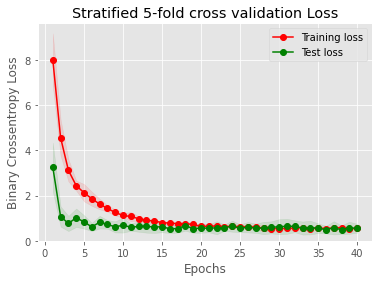

Accuracy: 0.70 (+/- 0.09)
AUC: 0.86 (+/- 0.12)


In [49]:
plot_loocv_loss(fold_train_loss, fold_test_loss, "Stratified 5-fold cross validation Loss")
# Transform the lists into numpy arrays for calculations
acc_per_fold=np.array(acc_per_fold)
auc_per_fold=np.array(auc_per_fold)

# Display the results
print(f"Accuracy: {acc_per_fold.mean():.2f} (+/- {acc_per_fold.std():.2f})")
print(f"AUC: {auc_per_fold.mean():.2f} (+/- {auc_per_fold.std():.2f})")

**And the performance on unseen data?**

In [52]:
result = model.evaluate(test_data[0], test_data[1], batch_size=64)
result = dict(zip(model.metrics_names, result))
print(result)

2/2 [==============================] - 0s 64ms/step - loss: 0.3973 - binary_accuracy: 0.8273 - auc: 0.9240
{'loss': 0.3973306715488434, 'binary_accuracy': 0.8272727131843567, 'auc': 0.9239669442176819}
